softmax 多类分类 求得每一类的概率

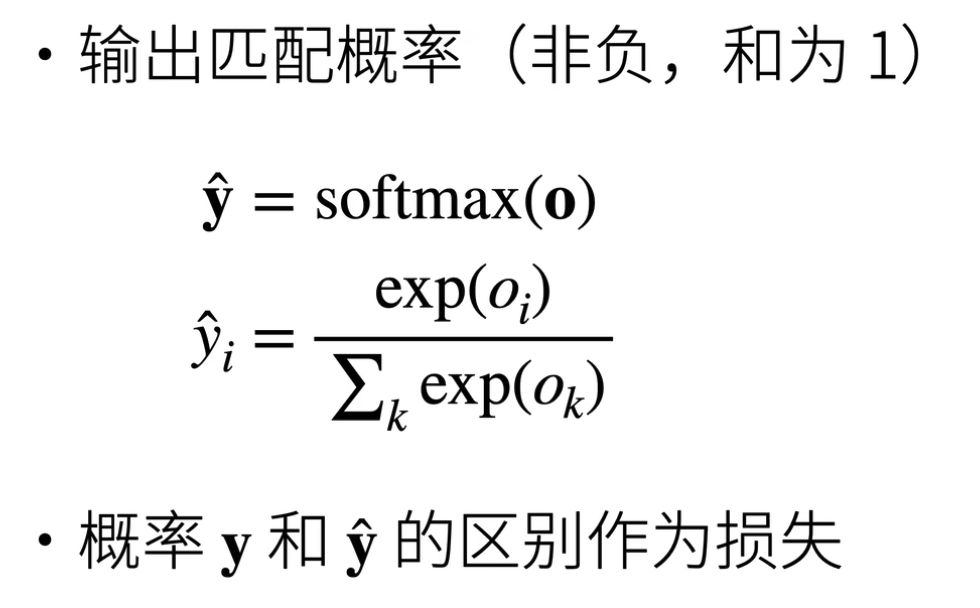

交叉熵 对比损失
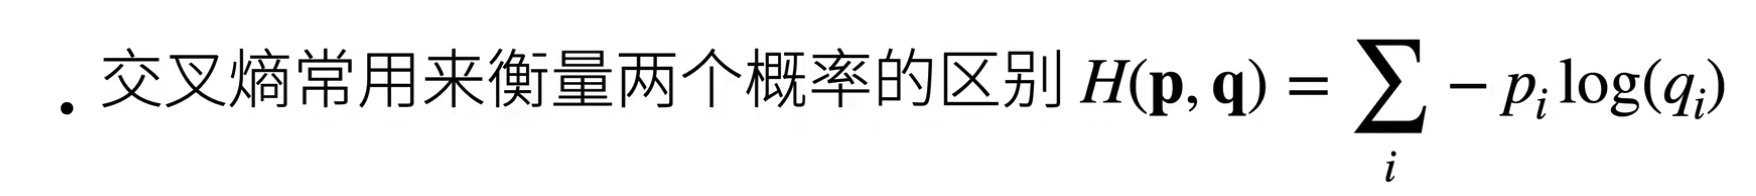
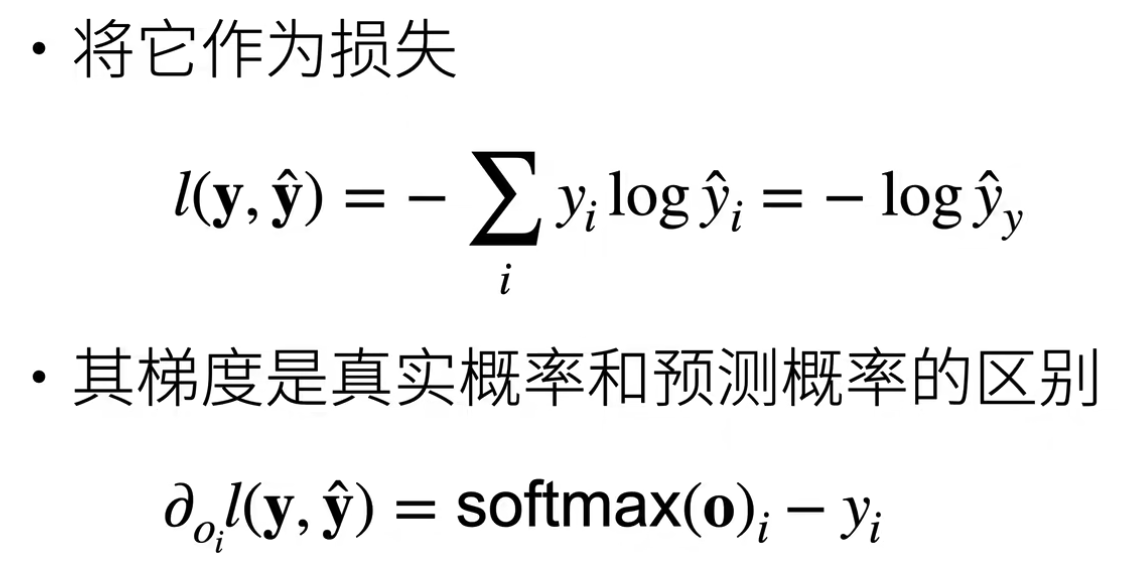

## 损失函数

1. L2 loss MSE  距离零点比较远的地方，梯度变化比较大
2. L1 loss MAE  非零点的部分梯度都是恒定值，但是零点的时候不可导，而且剧烈变化
3. huber's robust loss  介于以上2者中间
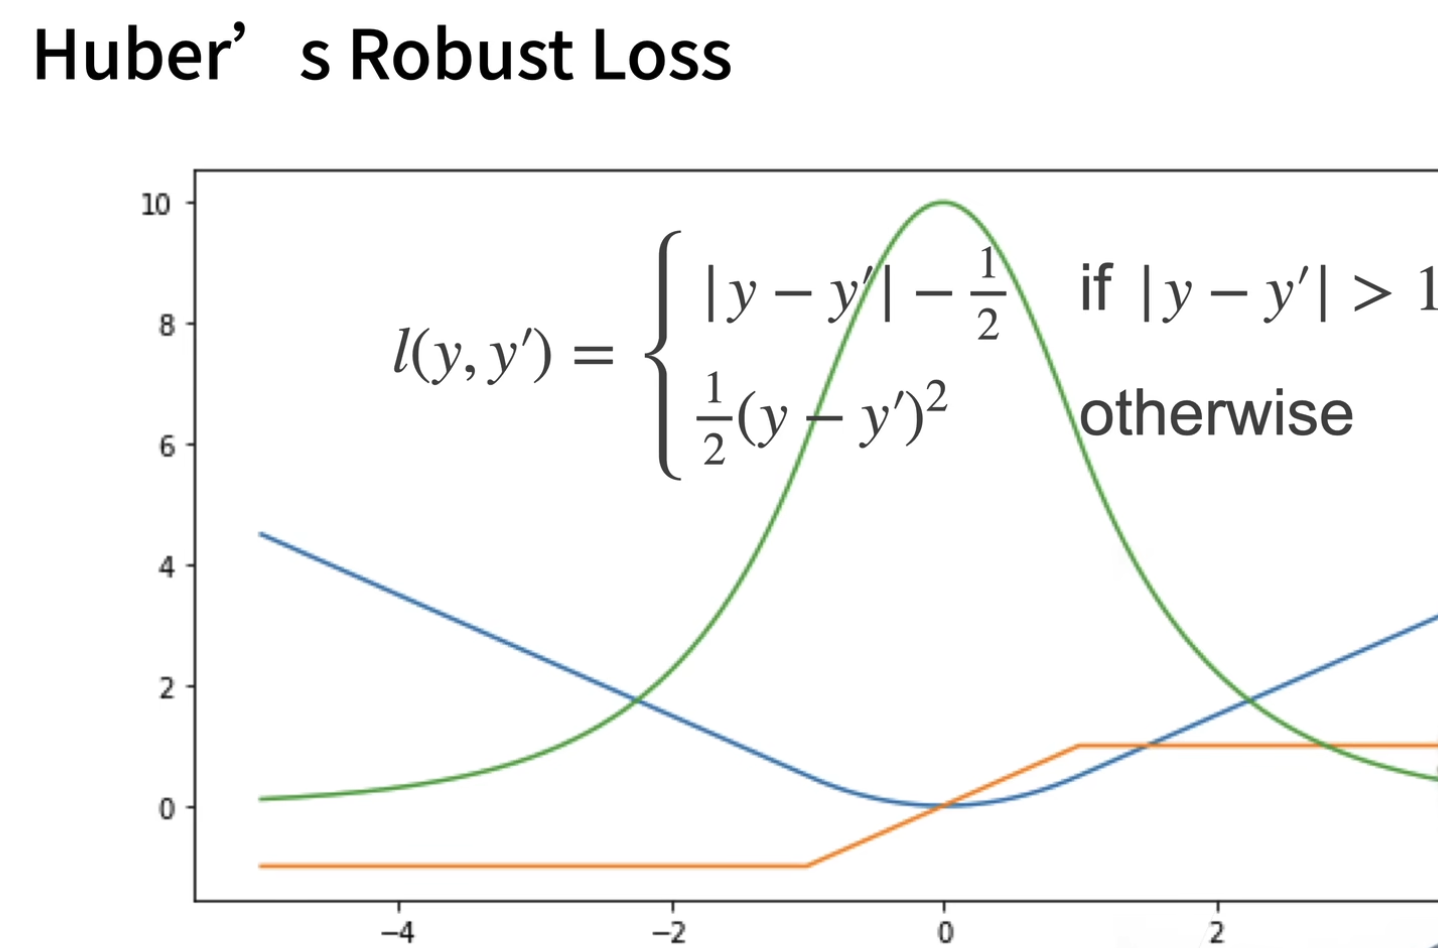



In [1]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

In [ ]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root='../DeepLearning/data', train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(root='../DeepLearning/data', train=False, transform=trans, download=True)

In [ ]:
len(mnist_train), len(mnist_test)

In [ ]:
mnist_train[0][0].shape

In [ ]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal',
                   'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

# _ 表示忽略，未使用的值
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    #return axes

In [ ]:
x, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(x.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y))

In [ ]:
batch_size = 256

def get_dataloader_workers():
    # 使用4个线程来读取数据
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=get_dataloader_workers())

timer = d2l.Timer()
for x, y in train_iter:
    continue

f'{timer.stop():.2f} sec'

In [ ]:
def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    
    mnist_train = torchvision.datasets.FashionMNIST(root='../DeepLearning/data', train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root='../DeepLearning/data', train=False, transform=trans, download=True)

    return (data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=get_dataloader_workers))

In [2]:
from IPython import display

In [3]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [4]:
num_inputs = 784 # 28*28
num_outputs = 10

w = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [ ]:
# x = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
# x.sum(0, keepdim=True), x.sum(1, keepdim=True)

In [5]:
def softmax(x):
    x_exp = torch.exp(x)
    partition = x_exp.sum(1, keepdim=True)
    return x_exp / partition

In [ ]:
# test
# x = torch.normal(0, 1, (2, 5))
# x_prob = softmax(x)
# x_prob, x_prob.sum(1)

In [6]:
def net(x):
    return softmax(torch.matmul(x.reshape((-1, w.shape[0])), w) + b)

In [ ]:
# y_hat 为取出 y 对应的在y_hat 里面标号对应的值
# y = torch.tensor([0, 2])
# y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
# y_hat[[0, 1], y]

In [7]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])

# cross_entropy(y_hat, y)

In [8]:
# 预测正确的数量，不是accuracy
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

# accuracy(y_hat, y) / len(y)

In [9]:
def evaluate_accuracy(net, data_iter):
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    for x, y in data_iter:
        metric.add(accuracy(net(x), y), y.numel())
    return metric[0] / metric[1]


In [11]:
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]


In [17]:
def train_epoch_ch3(net, train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)

    for x, y in train_iter:
        y_hat = net(x)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.step()
            # metric.add(float(1) * len(y), accuracy(y_hat, y), y.size().numel())
        else:
            l.sum().backward()
            updater(x.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    
    return metric[0] / metric[2], metric[1] / metric[2]

In [13]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [ ]:
# # example
# import math
# import time

# animator = Animator(xlabel='x', ylabel='sin(x)', legend=['sin(x)'])

# for i in range(100):
#     x = i / 10
#     y = math.sin(x)
#     animator.add(x, y)
#     time.sleep(0.1)

In [26]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics

    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [15]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([w, b], lr, batch_size)

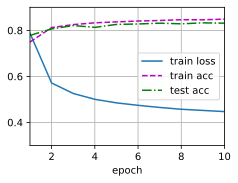

In [18]:
num_epochs = 10

train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

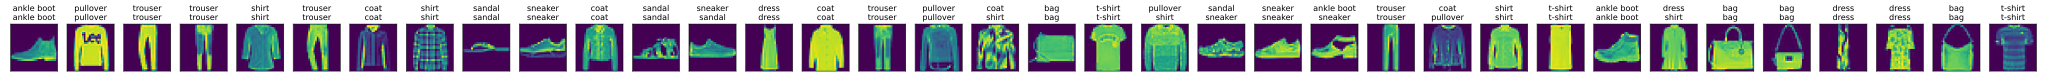

In [21]:
def predict_ch3(net, test_iter, n=36):  #@save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

In [23]:
from torch import nn

net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

In [24]:
loss = nn.CrossEntropyLoss()

trainer = torch.optim.SGD(net.parameters(), lr=0.1)

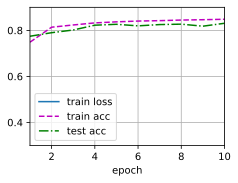

In [28]:
num_epochs = 10

train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)